In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [3]:
# 2. Đọc file csv
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,10760,10790,10760,10790,2410,IMP
1,1,2014-01-03,10760,10840,10670,10840,13010,IMP
2,2,2014-01-06,10870,11560,10870,11540,55630,IMP
3,3,2014-01-07,11400,11540,11330,11540,20980,IMP
4,4,2014-01-08,11370,11830,11330,11800,43410,IMP
...,...,...,...,...,...,...,...,...
2462,2462,2023-12-04,54700,55500,54400,55300,24800,IMP
2463,2463,2023-12-05,55200,55200,54600,55000,10200,IMP
2464,2464,2023-12-06,55000,55200,54900,55200,26600,IMP
2465,2465,2023-12-07,54900,55900,54900,55200,29200,IMP


In [4]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:1:2
df = pd.read_csv(company_csv)
df = df[['close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [5]:
!pip install pmdarima #co Successfully installed pmdarima-2.0.4 thi ko can cai lai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:00


In [6]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26653.776, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26651.763, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26647.778, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26647.783, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26652.732, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=26649.773, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26649.774, Time=3.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26651.774, Time=2.63 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=26649.137, Time=0.27 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 8.375 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

In [7]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [8]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[50035.65975348 50056.47485425 50079.32828281 50102.06247412
 50124.80364053 50147.54439891 50170.28518115 50193.02596201
 50215.76674294 50238.50752387 50261.2483048  50283.98908572
 50306.72986665 50329.47064758 50352.21142851 50374.95220944
 50397.69299037 50420.4337713  50443.17455223 50465.91533316
 50488.65611408 50511.39689501 50534.13767594 50556.87845687
 50579.6192378  50602.36001873 50625.10079966 50647.84158059
 50670.58236152 50693.32314244]


In [9]:
# 7. Đánh giá độ chính xác validate, test
# valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
# test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
# print('Validation RMSE:', valid_rmse)
# print('Testing RMSE:', test_rmse)


# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# def evaluateModel(validate, testt)
#   valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
#   test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
#   print('Validation RMSE:', valid_rmse)
#   print('Testing RMSE:', test_rmse)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MAE, RMSE, R-square cho testing
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mape_test = calculate_mape(y_test, y_pred)
r_squared_test = r2_score(y_test, y_pred)

# Tính MAE, RMSE cho validation
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
mape_val = calculate_mape(y_val, y_pred_val)
r_squared_val = r2_score(y_val, y_pred_val)

# In kết quả
print('---------VALIDATE----------')
print("MAE:", round(mae_val, 3))
print("RMSE:", round(rmse_val, 3))
print("MAPE:", round(mape_val, 3))
print("R-squared:", round(r_squared_val, 3))
print('--------------------------')
print('---------TEST----------')
print("MAE:", round(mae_val, 3))
print("RMSE:", round(rmse_test, 3))
print("MAPE:", round(mape_test, 3))
print("R-squared:", round(r_squared_test, 3))
print('-------------------')



---------VALIDATE----------
MAE: 5648.963
RMSE: 6962.854
MAPE: 9.64
R-squared: -0.063
--------------------------
---------TEST----------
MAE: 5648.963
RMSE: 10833.288
MAPE: 14.187
R-squared: -1.261
-------------------


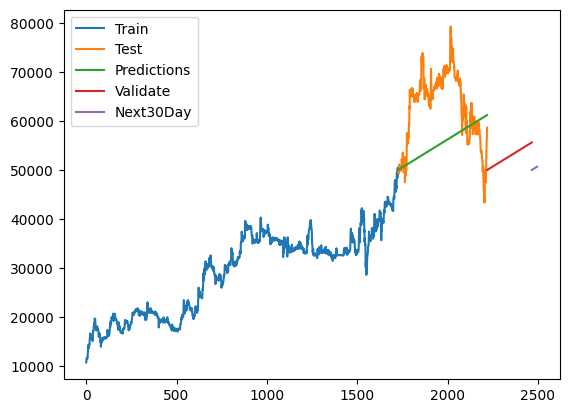

In [10]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['close'])
plt.plot(test_data.index, test_data['close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [11]:
test_data.index

RangeIndex(start=1726, stop=2219, step=1)